In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

import warnings
warnings.filterwarnings("ignore")

In [9]:
url = "https://raw.githubusercontent.com/pedroteche-ih/DAFT_MEX_202209/main/data/tb_ames_housing.csv"
tb_housing = pd.read_csv(url)
clu_vars = [
    "LotFrontage",
    "LotArea",
    "OverallQual",
    "OverallCond",
    "MasVnrArea",
    "BsmtFinSF1",
    "BsmtFinSF2",
    "BsmtUnfSF",
    "TotalBsmtSF",
    "1stFlrSF",
    "2ndFlrSF",
    "LowQualFinSF",
    "GrLivArea",
    "BsmtFullBath",
    "BsmtHalfBath",
    "FullBath",
    "HalfBath",
    "BedroomAbvGr",
    "KitchenAbvGr",
    "TotRmsAbvGrd",
    "Fireplaces",
    "GarageCars",
    "GarageArea",
    "WoodDeckSF",
    "OpenPorchSF",
    "EnclosedPorch",
    "3SsnPorch",
    "ScreenPorch",
    "PoolArea",
    "MiscVal"
]
tb_housing = tb_housing.dropna(subset=clu_vars)

# Visualizando Estrutura de Correlação

Até agora vimos duas formas de tratar colinearidade: através da seleção manual de variáveis utilizando a matriz de correlação e utilizando PCA. Hoje veremos mais técnicas exploratórias para visualizar nosso espaço de features.

<Axes: >

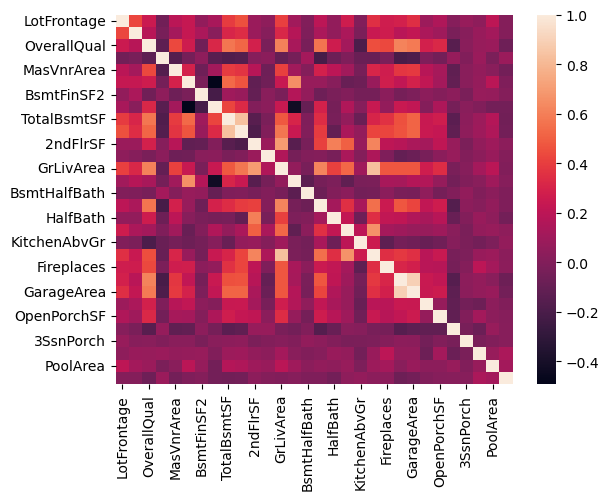

In [10]:
sns.heatmap(tb_housing[clu_vars].corr())

# Utilizando HACs

Como vimos na aula passada, HACs são ferramentas poderosas que nos permitem agrupar de forma hierarquica as observações de um dataset. HACs tem uma limitação: não escalam bem conforme **aumentamos o número de pontos em um dataset**.

Para utilizar um HAC para clusterizar nossas variáveis basta perceber que se **transpormos** nossa matriz de dados nossas *observações serão nossas variáveis!* Além de permitir clusterizar nossas variáveis, isto contorna a principal limitação dos HACs: mesmo que nosso dataset contenha centena de *features* não teremos problemas com limitações de memória e processamento.

In [11]:
scaler = StandardScaler()
tb_sca_housing_num = scaler.fit_transform(tb_housing[clu_vars])


In [12]:
tb_sca_housing_num.shape

(1195, 30)

Poddemos usar o atributo `.T` para acessar a matriz transposta:

In [13]:
tb_sca_housing_num.T.shape


(30, 1195)

Uma consideração importante a se fazer quando agrupamos variáveis utilizando um HAC é a definição da distância: embora a distância euclideana seja suficiente para maior parte dos problemas ela não é uma boa função de distância para medir semelhança entre variáveis.

Uma medida que já aprendemos nos permite estimar bem esta semelhança: a distância de correlação.

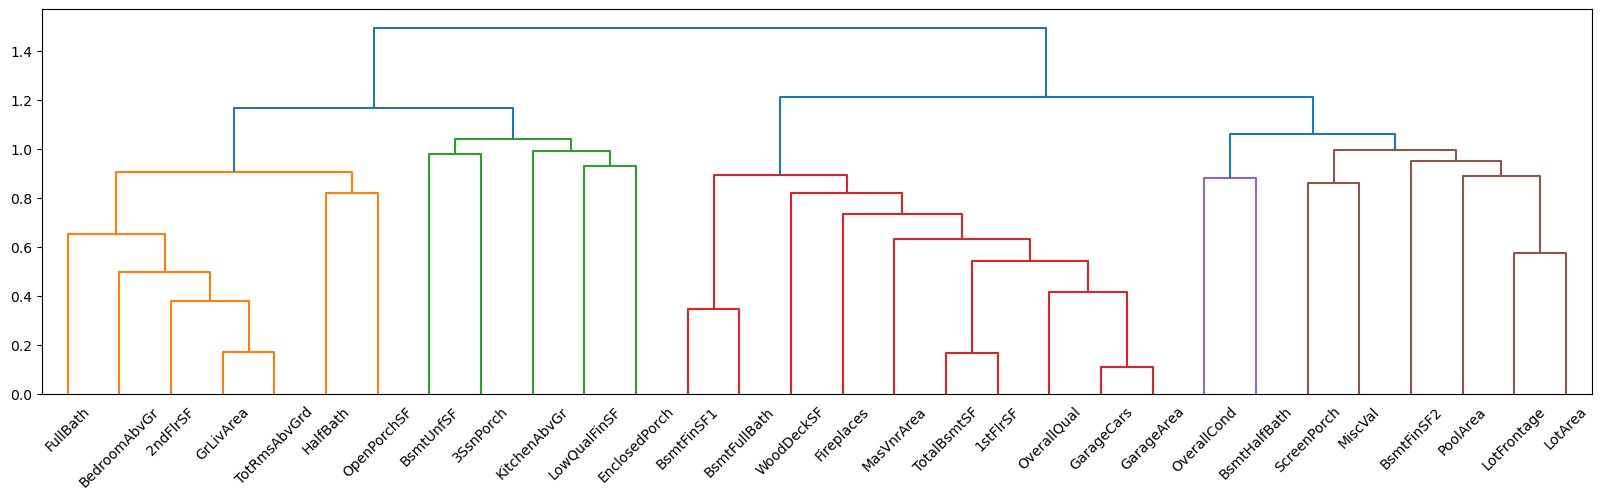

In [17]:
fig = plt.figure(figsize=(20, 5))
link = linkage(tb_sca_housing_num.T, method="complete", metric="cosine")
housing_dendogram = dendrogram(link, labels=scaler.feature_names_in_)


Vamos investigar a matriz de correlação do primeiro grupo de variáveis (à distância 0.8):

<Axes: >

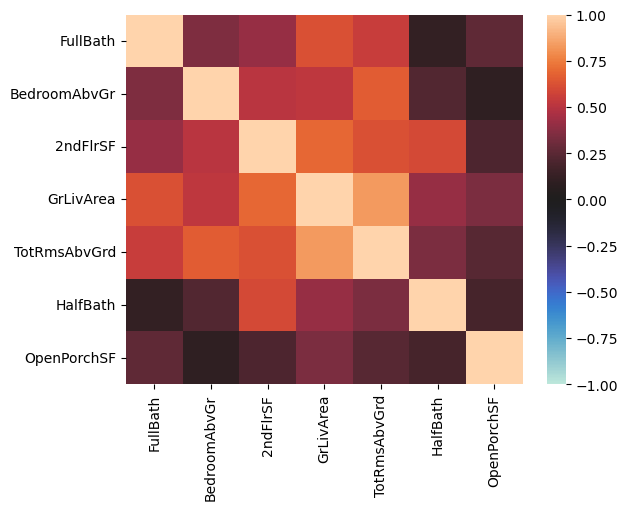

In [18]:
clu_0 = [
    "FullBath",
    "BedroomAbvGr",
    "2ndFlrSF",
    "GrLivArea",
    "TotRmsAbvGrd",
    "HalfBath",
    "OpenPorchSF",
]
sns.heatmap(tb_housing[clu_0].corr(), vmin=-1, center=0, vmax=1)


Esta técnica de agrupamento de features é muito utilizada como **ferramenta exploratória**, complementar a utilização da matriz de correlação. Mesmo assim, podemos utilizar a função `FeatureAgglomeration` para calcular uma transformação a partir dos agrupamentos estimados:

In [19]:
from sklearn.cluster import FeatureAgglomeration

In [20]:
n = 5
var_fit = FeatureAgglomeration(n_clusters=n, affinity='cosine', linkage='complete')
var_fit.fit(tb_sca_housing_num)


/Users/pedroteche/miniconda3/envs/optuna/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


FeatureAgglomeration(affinity='cosine', linkage='complete', n_clusters=5)

In [21]:
tb_var_cluster = pd.DataFrame(
    var_fit.transform(tb_sca_housing_num), 
    columns=["CLU_" + str(i) for i in range(n)]
)
tb_var_cluster.head()

,CLU_0,CLU_1,CLU_2,CLU_3,CLU_4
0,-0.361984,-0.191716,0.063467,0.698823,-0.373469
1,-0.302244,-0.064602,0.315289,-0.296102,3.131200
2,-0.235371,-0.112334,0.214715,0.506722,-0.373469
3,0.692607,-0.202944,0.186889,-0.020641,-0.373469
4,-0.210405,0.060697,0.922624,1.209720,-0.373469


# Multi-Dimensional Scaling (MDS)

A primeira técnica não-supervisionada que aprendemos foi PCA - uma técnica que busca uma **projeção** de nossos dados em um espaço dimensional reduzido, eliminando colinearidades. Uma das limitações de PCA é que reduzimos apenas relações lineares: se duas variáveis tem uma relação não-linear, PCA não irá capturar este padrão.

Nesses casos podemos utilizar outra técnica exploratória: **MDS**. MDS (*multi-dimensional scaling*) é uma técnica semelhante à PCA mas que utiliza a proximidade entre observações para criar uma mapa de dimensionalidade reduzida. Podemos pensar nesta operação como a criação de um mapa mundi a partir de um globo: reduzimos as dimensões de nosso dataset enquanto tentamos manter as *similaridades locais* do espaço original.

## Utilizando MDS para Clusterização

In [22]:
from sklearn.manifold import MDS

In [23]:
url = 'https://raw.githubusercontent.com/pedroteche-ih/DAFT_MEX_202209/main/data/tb_household_electricity.csv'
tb_house = pd.read_csv(url, parse_dates = ['date_time'])
tb_house.head()

,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3,date_time
0,2.268,0.000,235.94,9.6,0.0,0.0,17.0,2008-01-23 21:14:00
1,4.152,0.354,238.13,17.4,1.0,38.0,17.0,2008-02-02 16:42:00
2,1.448,0.212,240.99,6.0,0.0,2.0,18.0,2008-03-21 11:29:00
3,0.284,0.072,237.66,1.2,0.0,0.0,0.0,2008-02-28 10:13:00
4,0.452,0.084,239.81,1.8,0.0,0.0,0.0,2007-03-07 20:10:00


In [24]:
tb_house = tb_house.sample(1000, random_state=42).copy()
tb_house = tb_house.drop('date_time', axis = 1)
clu_vars_h = ['sub_metering_1', 'sub_metering_2', 'sub_metering_3']


In [25]:
scaler = StandardScaler()
scaler.fit(tb_house[clu_vars_h])
tb_sca_cp = pd.DataFrame(
    scaler.transform(tb_house[clu_vars_h]),
    columns = scaler.feature_names_in_
)

tb_sca_cp.head()

,sub_metering_1,sub_metering_2,sub_metering_3
0,-0.176843,-0.228821,-0.759886
1,-0.176843,-0.228821,1.398199
2,-0.176843,-0.228821,-0.759886
3,3.383750,-0.228821,1.278306
4,-0.176843,-0.228821,-0.759886


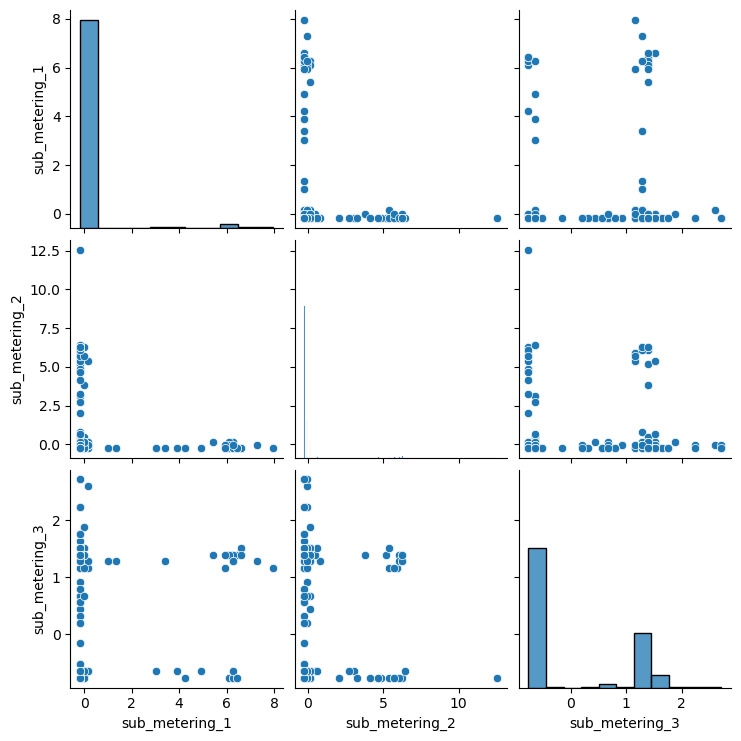

In [26]:
sns.pairplot(tb_sca_cp)

In [27]:
mds_fit = MDS(n_components=2, random_state = 42)
mds_array = mds_fit.fit_transform(tb_sca_cp)

tb_mca_house = pd.DataFrame(
    mds_array,
    columns = ['MC_0', 'MC_1']
)

/Users/pedroteche/miniconda3/envs/optuna/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


<Axes: xlabel='MC_0', ylabel='MC_1'>

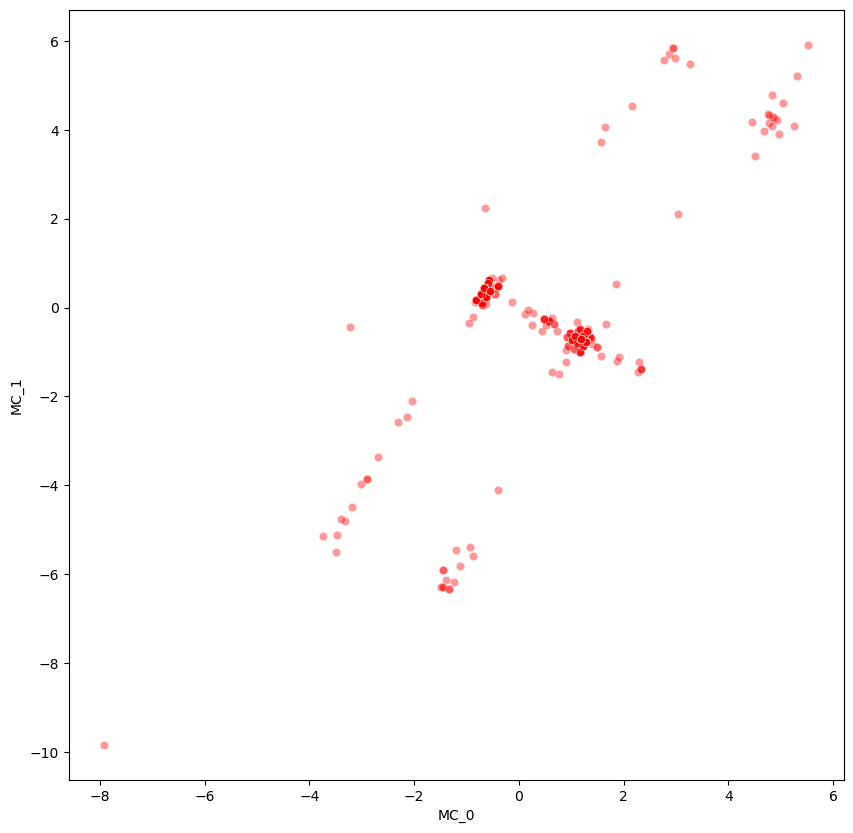

In [28]:
fig, ax = plt.subplots(1, 1, figsize = (10,10))
sns.scatterplot(data = tb_mca_house, x = 'MC_0', y = 'MC_1', color = 'red', alpha = 0.4)

/Users/pedroteche/miniconda3/envs/optuna/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<Axes: xlabel='MC_0', ylabel='MC_1'>

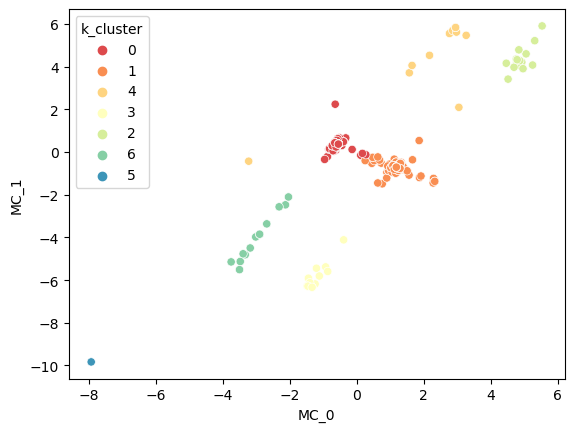

In [30]:
k_fit = KMeans(n_clusters = 7)
k_fit.fit(tb_sca_cp)
tb_mca_house['k_cluster'] = [str(x) for x in k_fit.labels_]
sns.scatterplot(data = tb_mca_house, x = 'MC_0', y = 'MC_1', hue = 'k_cluster', palette='Spectral')

In [31]:
tb_sca_cp['k_cluster'] = tb_mca_house['k_cluster']
tb_house_melt = tb_sca_cp.melt(id_vars = ['k_cluster'])

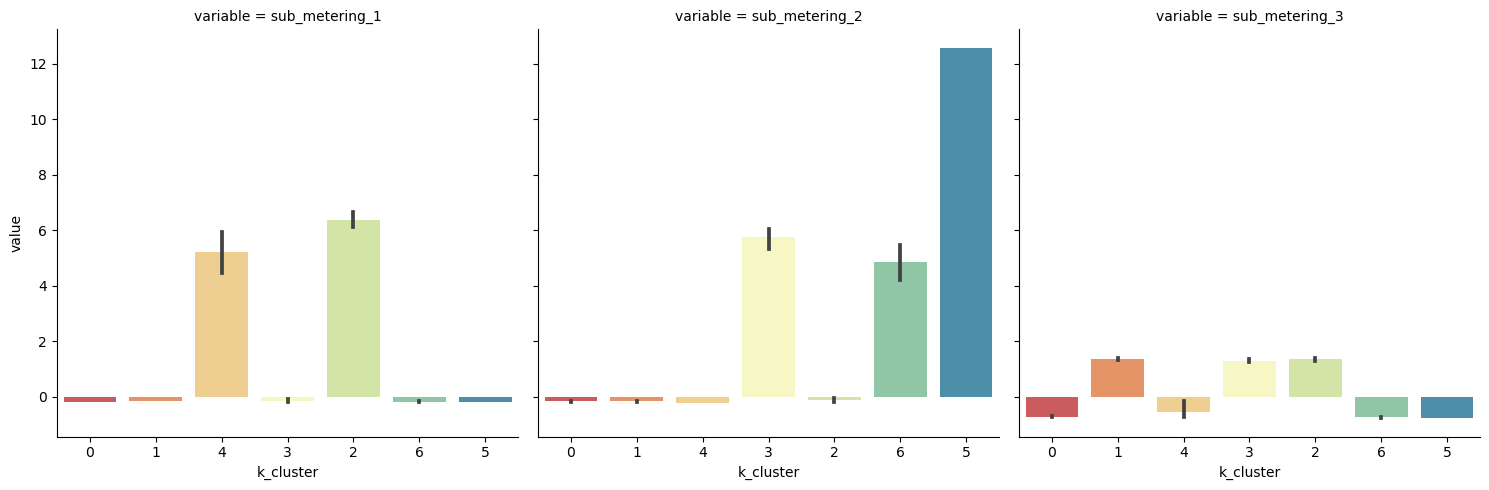

In [32]:
sns.catplot(data = tb_house_melt, x = 'k_cluster', y = 'value', col= 'variable', kind = 'bar', col_wrap = 3, palette = 'Spectral')

# t-SNE

t-SNE é uma técnica altamente não linear que pode ser vista como uma extensão de MDS: enquanto MDS tenta preservar a distância entre todos os pontos do dataset após a transformação, t-SNE busca manter apenas as distância entre pontos próximos. É uma técnica altamente não-linear e deve ser usada com cuidado: é muito comum enxergarmos padrões onde estes não existem.

Para mitigar este risco, devemos variar o hiperparâmetro `perplexity`, visualizando diferentes representações de nossos dados.

Para quem quiser se aprofundar neste algoritmo: https://distill.pub/2016/misread-tsne/

In [33]:
import umap

/Users/pedroteche/miniconda3/envs/optuna/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/pedroteche/miniconda3/envs/optuna/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/pedroteche/miniconda3/envs/optuna/lib/python3.10/si